# FasionMNIST

In [1]:
import numpy as np

import torch  # pytorch를 위한 패키지
import torchvision  # computer vision을 위한 패키지

from torch.utils.data import Dataset
from torchvision import datasets, transforms

print(torch.__version__)
print(torchvision.__version__)

1.13.0+cpu
0.14.0+cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
train_data = datasets.FashionMNIST(root='data', 
                                   train=True,        # 학습용 데이터셋 설정(True)
                                   download=True, 
                                   transform=transform     # 정규화            
                                  )

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [6]:
test_data = datasets.FashionMNIST(root='data', 
                                  train=False,        # 검증용 데이터셋 설정(False)
                                  download=True, 
                                  transform=transform
                                 )

In [4]:
import matplotlib.pyplot as plt

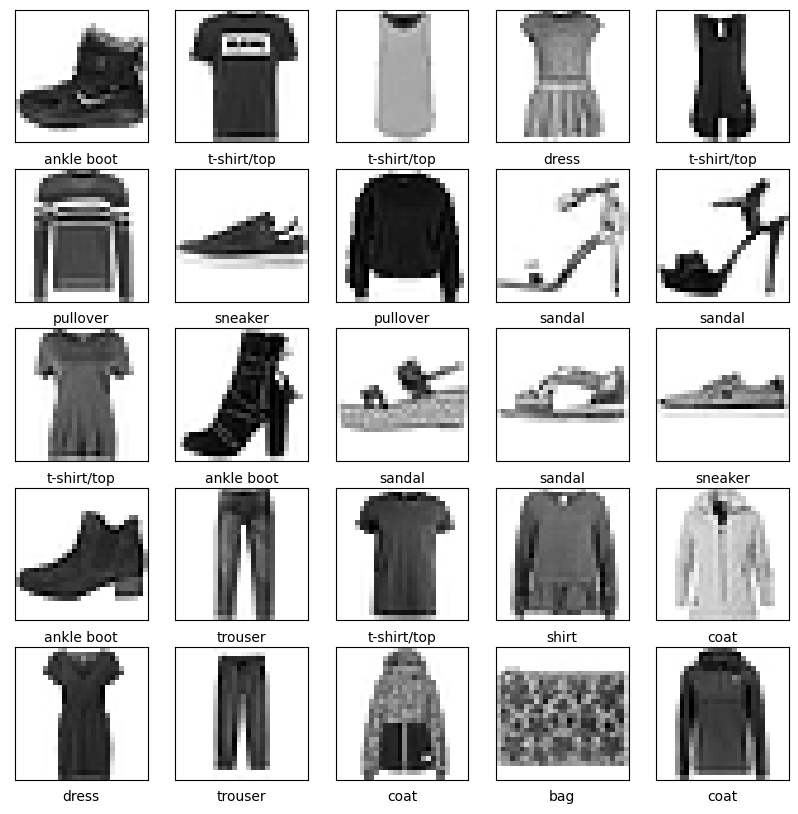

In [5]:
class_names = {
    0: "t-shirt/top", 
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)  # 그래프의 표시 위치
    img, label = train_data[i]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)  # 그리드선
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [7]:
import os
os.cpu_count()

8

In [8]:
batch_size = 32  # batch_size 지정
num_workers = 6  # Thread 숫자 지정

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=num_workers)

In [10]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=False, 
                                          num_workers=num_workers)

In [11]:
# 1개의 배치 추출 후 Image, label의 shape 출력
img, lbl = next(iter(train_loader))
img.shape, lbl.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

- 배치 사이즈가 32, 채널(1), 세로(28), 가로(28)

In [12]:
torch.cuda.is_available()

False

- False면 디바이스가 cpu를 사용하는 것, 아니면 GPU를 사용중이라는 뜻

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


- GPU가 지정되어 있다면 cuda:0, 2대는 cuda:1로 지정

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 10)
    
    def forward(self, x):
        # 텐서는 같지만 새로운 텐서 반환(모양 변환)
        x = x.view(-1, 28*28)   # tensorflow의 reshape역할
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x     

In [16]:
model = DNNModel() # Model 생성
model.to(device)   # device 로드

DNNModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()

In [20]:
from tqdm import tqdm

In [21]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    
    # 초기화
    total_batch_loss = 0   # 총 손실
    total_num = 0          # 정답 개수
    
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올리기.
        img, lbl = img.to(device), lbl.to(device)
        
        optimizer.zero_grad()  # 그래디언트 초기화
        output = model(img)    # Forward Propagation을 진행. 결과 획득.
        
        loss = loss_fn(output, lbl) # 손실 계산
        loss.backward()   # 오차역전파(Back Propagation) 진행. 미분 값을 계산
        optimizer.step()  # 가중치 업데이트 
        
        # output의 max(dim=1)은 max probability와 max index를 반환.
        # max probability는 무시하고, max index는 pred에 저장
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. 
        # item()은 tensor에서 값을 추출.
        total_num += pred.eq(lbl).sum().item() # 
        
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        # total_batch_loss에 1개 배치의 전체 loss를 더하기
        total_batch_loss += loss.item() * img.size(0) 
        
    acc = total_num / len(data_loader.dataset) # 정확도 계산
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return total_batch_loss / len(data_loader.dataset), acc

In [22]:
def model_evaluate(model, data_loader, loss_fn, device):
    model.eval()  # model.eval()은 모델을 평가모드로 설정 변경
    
    with torch.no_grad():
        # 손실과 정확도 계산을 위한 초기화
        total_num = 0
        total_batch_loss = 0
        
        # 배치별 evaluation을 진행
        for img, lbl in data_loader:
            
            # device에 데이터를 올리기
            img, lbl = img.to(device), lbl.to(device)

            output = model(img) # Forward Propagation을 진행. 결과 획득.

            # output의 max(dim=1)은 max probability와 max index를 반환.
            _, pred = output.max(dim=1)
            total_num += torch.sum(pred.eq(lbl)).item()  # 정확한 것 개수 더하기(누적)
            
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            total_batch_loss += loss_fn(output, lbl).item() * img.size(0)
        
        acc = total_num / len(data_loader.dataset)  # 정확도 계산
        
        # 결과를 반환 - val_loss, val_acc
        return total_batch_loss / len(data_loader.dataset), acc

In [23]:
%%time

# epochs 지정, 최소 손실 초기화
num_epochs = 20
min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # 모델 학습 - 학습 손실과 정확도를 얻기
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 모델 검증 - 검증 손실과 검증 정확도를 얻기
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss가 개선시, model의 가중치(weights)를 저장.
    if val_loss < min_loss:
        print(f'[INFO] val_loss 개선 from {min_loss:.5f} to {val_loss:.5f}. 모델 저장!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력
    print(f"epoch {epoch+1:02d}")
    print(f"loss: {train_loss:.5f}, acc: {train_acc:.5f}", end="   ")
    print(f"val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}")

100%|██████████████████████████████████████████| 1875/1875 [00:06<00:00, 290.76it/s]


[INFO] val_loss 개선 from inf to 0.47405. 모델 저장!
epoch 01
loss: 0.59253, acc: 0.79152   val_loss: 0.47405, val_accuracy: 0.83410


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 253.78it/s]


[INFO] val_loss 개선 from 0.47405 to 0.44234. 모델 저장!
epoch 02
loss: 0.41462, acc: 0.85240   val_loss: 0.44234, val_accuracy: 0.84460


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 250.14it/s]


[INFO] val_loss 개선 from 0.44234 to 0.38388. 모델 저장!
epoch 03
loss: 0.37130, acc: 0.86792   val_loss: 0.38388, val_accuracy: 0.86380


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 228.26it/s]


[INFO] val_loss 개선 from 0.38388 to 0.37111. 모델 저장!
epoch 04
loss: 0.33951, acc: 0.87777   val_loss: 0.37111, val_accuracy: 0.86910


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 252.19it/s]


[INFO] val_loss 개선 from 0.37111 to 0.34857. 모델 저장!
epoch 05
loss: 0.31884, acc: 0.88372   val_loss: 0.34857, val_accuracy: 0.87580


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 229.51it/s]


[INFO] val_loss 개선 from 0.34857 to 0.34133. 모델 저장!
epoch 06
loss: 0.30193, acc: 0.89037   val_loss: 0.34133, val_accuracy: 0.87790


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 228.03it/s]


epoch 07
loss: 0.28833, acc: 0.89348   val_loss: 0.35931, val_accuracy: 0.87240


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 228.54it/s]


epoch 08
loss: 0.27717, acc: 0.89837   val_loss: 0.34700, val_accuracy: 0.87340


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 250.52it/s]


epoch 09
loss: 0.26484, acc: 0.90255   val_loss: 0.35508, val_accuracy: 0.87100


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 258.72it/s]


epoch 10
loss: 0.25533, acc: 0.90488   val_loss: 0.38005, val_accuracy: 0.87290


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 241.33it/s]


[INFO] val_loss 개선 from 0.34133 to 0.33296. 모델 저장!
epoch 11
loss: 0.24715, acc: 0.90877   val_loss: 0.33296, val_accuracy: 0.88460


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.49it/s]


[INFO] val_loss 개선 from 0.33296 to 0.32903. 모델 저장!
epoch 12
loss: 0.23875, acc: 0.91212   val_loss: 0.32903, val_accuracy: 0.88560


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 244.98it/s]


epoch 13
loss: 0.23181, acc: 0.91358   val_loss: 0.36333, val_accuracy: 0.87190


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 250.29it/s]


epoch 14
loss: 0.22452, acc: 0.91640   val_loss: 0.33491, val_accuracy: 0.88320


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 266.41it/s]


[INFO] val_loss 개선 from 0.32903 to 0.32723. 모델 저장!
epoch 15
loss: 0.21852, acc: 0.91937   val_loss: 0.32723, val_accuracy: 0.88790


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 266.28it/s]


epoch 16
loss: 0.21119, acc: 0.92135   val_loss: 0.33385, val_accuracy: 0.88220


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 264.28it/s]


epoch 17
loss: 0.20723, acc: 0.92343   val_loss: 0.33577, val_accuracy: 0.88540


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 261.09it/s]


epoch 18
loss: 0.20023, acc: 0.92563   val_loss: 0.34076, val_accuracy: 0.88160


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 260.95it/s]


epoch 19
loss: 0.19554, acc: 0.92692   val_loss: 0.34369, val_accuracy: 0.88620


100%|██████████████████████████████████████████| 1875/1875 [00:09<00:00, 206.40it/s]


epoch 20
loss: 0.19129, acc: 0.92933   val_loss: 0.33701, val_accuracy: 0.88810
CPU times: total: 6min 24s
Wall time: 3min 39s


In [24]:
# 가중치 로드
model.load_state_dict(torch.load('DNNModel.pth')) 

# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 계산
loss, acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'검증 손실: {loss:.5f}, 평가 정확도: {acc:.5f}')

검증 손실: 0.32723, 평가 정확도: 0.88790


## 파라미터 변경

In [32]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)
    
    def forward(self, x):
        # 텐서는 같지만 새로운 텐서 반환(모양 변환)
        x = x.view(-1, 28*28)   # tensorflow의 reshape역할
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x     

In [33]:
model = DNNModel() # Model 생성
model.to(device)   # device 로드

DNNModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()

In [35]:
from tqdm import tqdm

In [36]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    
    # 초기화
    total_batch_loss = 0   # 총 손실
    total_num = 0          # 정답 개수
    
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올리기.
        img, lbl = img.to(device), lbl.to(device)
        
        optimizer.zero_grad()  # 그래디언트 초기화
        output = model(img)    # Forward Propagation을 진행. 결과 획득.
        
        loss = loss_fn(output, lbl) # 손실 계산
        loss.backward()   # 오차역전파(Back Propagation) 진행. 미분 값을 계산
        optimizer.step()  # 가중치 업데이트 
        
        # output의 max(dim=1)은 max probability와 max index를 반환.
        # max probability는 무시하고, max index는 pred에 저장
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. 
        # item()은 tensor에서 값을 추출.
        total_num += pred.eq(lbl).sum().item() # 
        
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        # total_batch_loss에 1개 배치의 전체 loss를 더하기
        total_batch_loss += loss.item() * img.size(0) 
        
    acc = total_num / len(data_loader.dataset) # 정확도 계산
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return total_batch_loss / len(data_loader.dataset), acc

In [37]:
def model_evaluate(model, data_loader, loss_fn, device):
    model.eval()  # model.eval()은 모델을 평가모드로 설정 변경
    
    with torch.no_grad():
        # 손실과 정확도 계산을 위한 초기화
        total_num = 0
        total_batch_loss = 0
        
        # 배치별 evaluation을 진행
        for img, lbl in data_loader:
            
            # device에 데이터를 올리기
            img, lbl = img.to(device), lbl.to(device)

            output = model(img) # Forward Propagation을 진행. 결과 획득.

            # output의 max(dim=1)은 max probability와 max index를 반환.
            _, pred = output.max(dim=1)
            total_num += torch.sum(pred.eq(lbl)).item()  # 정확한 것 개수 더하기(누적)
            
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            total_batch_loss += loss_fn(output, lbl).item() * img.size(0)
        
        acc = total_num / len(data_loader.dataset)  # 정확도 계산
        
        # 결과를 반환 - val_loss, val_acc
        return total_batch_loss / len(data_loader.dataset), acc

In [38]:
%%time

# epochs 지정, 최소 손실 초기화
num_epochs = 20
min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # 모델 학습 - 학습 손실과 정확도를 얻기
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 모델 검증 - 검증 손실과 검증 정확도를 얻기
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss가 개선시, model의 가중치(weights)를 저장.
    if val_loss < min_loss:
        print(f'[INFO] val_loss 개선 from {min_loss:.5f} to {val_loss:.5f}. 모델 저장!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력
    print(f"epoch {epoch+1:02d}")
    print(f"loss: {train_loss:.5f}, acc: {train_acc:.5f}", end="   ")
    print(f"val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}")

100%|██████████████████████████████████████████| 1875/1875 [00:06<00:00, 274.01it/s]


[INFO] val_loss 개선 from inf to 0.48068. 모델 저장!
epoch 01
loss: 0.62501, acc: 0.77835   val_loss: 0.48068, val_accuracy: 0.83210


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 238.43it/s]


[INFO] val_loss 개선 from 0.48068 to 0.43855. 모델 저장!
epoch 02
loss: 0.41622, acc: 0.85117   val_loss: 0.43855, val_accuracy: 0.84230


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 229.62it/s]


[INFO] val_loss 개선 from 0.43855 to 0.38049. 모델 저장!
epoch 03
loss: 0.36753, acc: 0.86782   val_loss: 0.38049, val_accuracy: 0.86530


100%|██████████████████████████████████████████| 1875/1875 [00:09<00:00, 205.40it/s]


[INFO] val_loss 개선 from 0.38049 to 0.36844. 모델 저장!
epoch 04
loss: 0.34067, acc: 0.87580   val_loss: 0.36844, val_accuracy: 0.86830


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 228.29it/s]


epoch 05
loss: 0.31808, acc: 0.88227   val_loss: 0.37836, val_accuracy: 0.86560


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 235.39it/s]


[INFO] val_loss 개선 from 0.36844 to 0.35636. 모델 저장!
epoch 06
loss: 0.30200, acc: 0.88820   val_loss: 0.35636, val_accuracy: 0.87300


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 241.46it/s]


[INFO] val_loss 개선 from 0.35636 to 0.34007. 모델 저장!
epoch 07
loss: 0.28830, acc: 0.89373   val_loss: 0.34007, val_accuracy: 0.88160


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 228.47it/s]


[INFO] val_loss 개선 from 0.34007 to 0.33675. 모델 저장!
epoch 08
loss: 0.27631, acc: 0.89777   val_loss: 0.33675, val_accuracy: 0.88050


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 222.57it/s]


epoch 09
loss: 0.26579, acc: 0.90080   val_loss: 0.33760, val_accuracy: 0.88160


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 226.01it/s]


[INFO] val_loss 개선 from 0.33675 to 0.33003. 모델 저장!
epoch 10
loss: 0.25524, acc: 0.90610   val_loss: 0.33003, val_accuracy: 0.88340


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 222.04it/s]


[INFO] val_loss 개선 from 0.33003 to 0.32560. 모델 저장!
epoch 11
loss: 0.24576, acc: 0.90747   val_loss: 0.32560, val_accuracy: 0.88540


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 224.18it/s]


epoch 12
loss: 0.23939, acc: 0.91008   val_loss: 0.32654, val_accuracy: 0.88730


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 225.78it/s]


epoch 13
loss: 0.23301, acc: 0.91255   val_loss: 0.33359, val_accuracy: 0.88510


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 223.76it/s]


epoch 14
loss: 0.22504, acc: 0.91582   val_loss: 0.35405, val_accuracy: 0.87430


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 235.80it/s]


[INFO] val_loss 개선 from 0.32560 to 0.32475. 모델 저장!
epoch 15
loss: 0.21763, acc: 0.91908   val_loss: 0.32475, val_accuracy: 0.89080


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 235.92it/s]


epoch 16
loss: 0.21299, acc: 0.91943   val_loss: 0.33436, val_accuracy: 0.88290


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 232.48it/s]


epoch 17
loss: 0.20705, acc: 0.92332   val_loss: 0.36057, val_accuracy: 0.88020


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 229.54it/s]


epoch 18
loss: 0.20137, acc: 0.92427   val_loss: 0.33177, val_accuracy: 0.89040


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 231.44it/s]


epoch 19
loss: 0.19423, acc: 0.92688   val_loss: 0.32893, val_accuracy: 0.89100


100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 244.70it/s]


epoch 20
loss: 0.19026, acc: 0.92862   val_loss: 0.33523, val_accuracy: 0.88920
CPU times: total: 7min 23s
Wall time: 3min 47s


In [39]:
# 가중치 로드
model.load_state_dict(torch.load('DNNModel.pth')) 

# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 계산
loss, acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'검증 손실: {loss:.5f}, 평가 정확도: {acc:.5f}')

검증 손실: 0.32475, 평가 정확도: 0.89080


-------------------------

### 검증 손실: 0.32723, 평가 정확도: 0.88790


### > 검증 손실: 0.32475, 평가 정확도: 0.89080 (FC층 하나 추가)

---------------------------

## 파라미터 변경2

In [40]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)
        #self.output = nn.Linear(32, 10)
    
    def forward(self, x):
        # 텐서는 같지만 새로운 텐서 반환(모양 변환)
        x = x.view(-1, 28*28)   # tensorflow의 reshape역할
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.output(x)
        return x     

In [41]:
model = DNNModel() # Model 생성
model.to(device)   # device 로드

DNNModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=10, bias=True)
)

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()

In [43]:
from tqdm import tqdm

In [44]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    
    # 초기화
    total_batch_loss = 0   # 총 손실
    total_num = 0          # 정답 개수
    
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올리기.
        img, lbl = img.to(device), lbl.to(device)
        
        optimizer.zero_grad()  # 그래디언트 초기화
        output = model(img)    # Forward Propagation을 진행. 결과 획득.
        
        loss = loss_fn(output, lbl) # 손실 계산
        loss.backward()   # 오차역전파(Back Propagation) 진행. 미분 값을 계산
        optimizer.step()  # 가중치 업데이트 
        
        # output의 max(dim=1)은 max probability와 max index를 반환.
        # max probability는 무시하고, max index는 pred에 저장
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. 
        # item()은 tensor에서 값을 추출.
        total_num += pred.eq(lbl).sum().item() # 
        
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        # total_batch_loss에 1개 배치의 전체 loss를 더하기
        total_batch_loss += loss.item() * img.size(0) 
        
    acc = total_num / len(data_loader.dataset) # 정확도 계산
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return total_batch_loss / len(data_loader.dataset), acc

In [45]:
def model_evaluate(model, data_loader, loss_fn, device):
    model.eval()  # model.eval()은 모델을 평가모드로 설정 변경
    
    with torch.no_grad():
        # 손실과 정확도 계산을 위한 초기화
        total_num = 0
        total_batch_loss = 0
        
        # 배치별 evaluation을 진행
        for img, lbl in data_loader:
            
            # device에 데이터를 올리기
            img, lbl = img.to(device), lbl.to(device)

            output = model(img) # Forward Propagation을 진행. 결과 획득.

            # output의 max(dim=1)은 max probability와 max index를 반환.
            _, pred = output.max(dim=1)
            total_num += torch.sum(pred.eq(lbl)).item()  # 정확한 것 개수 더하기(누적)
            
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            total_batch_loss += loss_fn(output, lbl).item() * img.size(0)
        
        acc = total_num / len(data_loader.dataset)  # 정확도 계산
        
        # 결과를 반환 - val_loss, val_acc
        return total_batch_loss / len(data_loader.dataset), acc

In [ ]:
%%time

# epochs 지정, 최소 손실 초기화
num_epochs = 20
min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # 모델 학습 - 학습 손실과 정확도를 얻기
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 모델 검증 - 검증 손실과 검증 정확도를 얻기
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss가 개선시, model의 가중치(weights)를 저장.
    if val_loss < min_loss:
        print(f'[INFO] val_loss 개선 from {min_loss:.5f} to {val_loss:.5f}. 모델 저장!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력
    print(f"epoch {epoch+1:02d}")
    print(f"loss: {train_loss:.5f}, acc: {train_acc:.5f}", end="   ")
    print(f"val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}")

100%|██████████████████████████████████████████| 1875/1875 [00:07<00:00, 245.46it/s]


[INFO] val_loss 개선 from inf to 0.52794. 모델 저장!
epoch 01
loss: 0.69683, acc: 0.74528   val_loss: 0.52794, val_accuracy: 0.81240


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 232.61it/s]


[INFO] val_loss 개선 from 0.52794 to 0.44068. 모델 저장!
epoch 02
loss: 0.44310, acc: 0.84237   val_loss: 0.44068, val_accuracy: 0.84270


100%|██████████████████████████████████████████| 1875/1875 [00:08<00:00, 226.25it/s]


In [ ]:
# 가중치 로드
model.load_state_dict(torch.load('DNNModel.pth')) 

# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 계산
loss, acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'검증 손실: {loss:.5f}, 평가 정확도: {acc:.5f}')